# Load Dataset

In [1]:
import time
import numpy as np

import datetime
import pandas as pd

number_of_lags = 10

lag_arr = []

sym = ['nvda','wmt','dash']

qry_string = ",".join([s.lower() for s in sym])

count=0
df = pd.DataFrame()
for s in sym[:]:

    tmp = pd.read_csv('stock_train.csv')
    tmp = tmp[tmp.sym==s][['sym','close', 'twitter_sentiment_3dy','gnews_sentiment_3dy','time']]

    if len(tmp)==0:
        print(s+' is empty')
        continue


    tmp = tmp.set_index('time')

#     tmp.index = [datetime.datetime.strptime(t,"%Y-%m-%d") for t in tmp.index]
    tmp.index = [datetime.datetime.strptime(t,"%Y-%m-%d %H:%M:%S") for t in tmp.index]
    
    tmp.columns = [s+'_'+c for c in tmp.columns]
    
    if count==0:
        df = tmp
    else:
        df = df.merge(tmp,left_index=True,right_index=True,how='outer')
    count+=1

In [2]:
from src.utils import null_percentages, heapsort, interpolate_nans
from src.signal import background_noise, trend_decomp, percent_change

#define features and target
close_features = ['nvda_close',
                'wmt_close',
               'dash_close']

sentiment_features = ['nvda_twitter_sentiment_3dy','nvda_gnews_sentiment_3dy',
                  'wmt_twitter_sentiment_3dy','wmt_gnews_sentiment_3dy',
                  'dash_twitter_sentiment_3dy','dash_gnews_sentiment_3dy']

features = close_features+sentiment_features

#I don't need to do this because I handle null processing in the data collection phase
#Specifically, I will pull the same data multiple times and use that to insert the missing values
for col in close_features:
    df.loc[:,col] = interpolate_nans(df[col]) 

for col in sentiment_features:
    df.loc[:,col] = interpolate_nans(df[col]) 
    

# Notice the background noise of DASH and WMT are similar


https://www.kaggle.com/zeemeen/i-have-a-clue-what-i-am-doing-noise-patterns

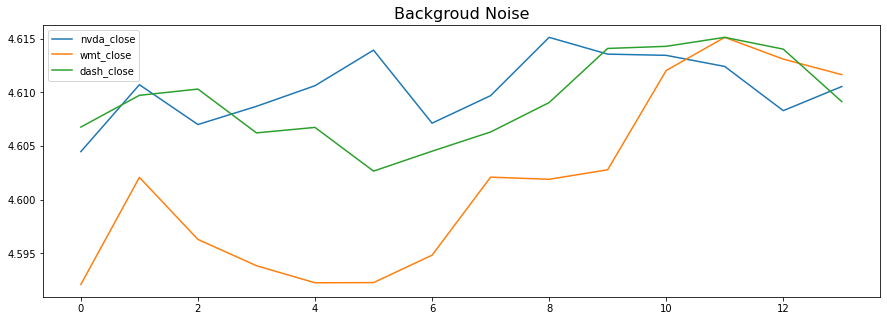

In [64]:
import matplotlib.pyplot as plt
W = 14
bnoise = np.zeros((len(close_features),W))
i=0
plt.figure(figsize=(15,5))
for col in close_features:
    bnoise[i] = background_noise(df[col].values,W)
    plt.plot(bnoise[i],label=col)
    i+=1
plt.title('Backgroud Noise',fontsize=16)
plt.legend()
plt.show()

# Time Series Plots

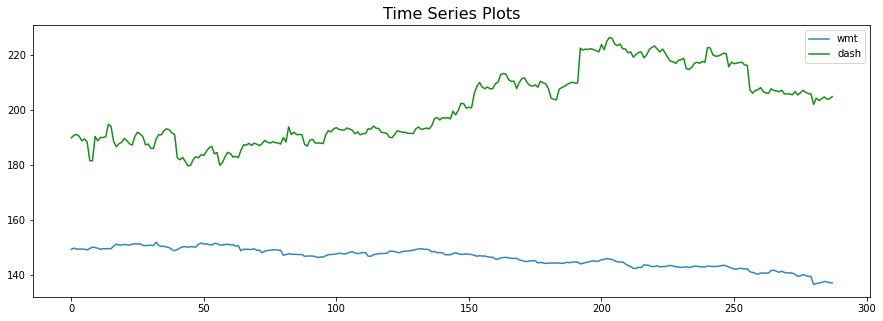

In [65]:
plt.figure(figsize=(15,5))
t = np.arange(0,df.shape[0])
plt.plot(t,df['wmt_close'].values,'-',alpha=0.9,label='wmt')
plt.plot(t,df['dash_close'].values,'g-',alpha=0.9,label='dash')
plt.title('Time Series Plots',fontsize=16)
plt.legend()
plt.show()

# Define Data Pipelines

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

keras = tf.keras

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

#python function
def get_fft(x):
    return np.absolute(np.fft.fft(x))
    
def X_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: w[:-1])
    ds = ds.map(lambda x: tf.ensure_shape(tf.py_function(get_fft, [x], [tf.float64])[0],x.shape))
    ds = ds.map(lambda w: tf.cast(w,tf.float32))
    return ds.batch(batch_size).prefetch(1)
  

def y_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: w[1:])
    return ds.batch(batch_size).prefetch(1)
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda x: tf.ensure_shape(tf.py_function(get_fft, [x], [tf.float64])[0],x.shape))
    ds = ds.map(lambda w: tf.cast(w,tf.float32))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [61]:
tf.random.set_seed(42)
np.random.seed(42)


t = np.arange(0,df.shape[0])
X = df[['dash_close','wmt_close']].values
y = df['dash_close'].values


split_time = int(X.shape[0]*0.8)
time_train = t[:split_time]
X_train = X[:split_time]
y_train = y[:split_time]
time_valid = t[split_time:]
X_valid = X[split_time:]
y_valid = y[split_time:]

window_size = 14

X_ds_train = X_window_dataset(X_train,window_size)
y_ds_train = y_window_dataset(y_train,window_size)
X_ds_valid = X_window_dataset(X_valid,window_size)
y_ds_valid = y_window_dataset(y_valid,window_size)


model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[window_size,2]))
for dilation_rate in (1, 2, 4):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
# model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1))


optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

train_dataset=tf.data.Dataset.zip((X_ds_train,y_ds_train)).shuffle(1000)
valid_dataset=tf.data.Dataset.zip((X_ds_valid,y_ds_valid)).shuffle(1000)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_dataset, epochs=500,
          validation_data=valid_dataset,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 0s 26ms/step - loss: 110.7188 - mae: 111.2188 - val_loss: 40.9749 - val_mae: 41.4749
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 29.3374 - mae: 29.8347 - val_loss: 22.4682 - val_mae: 22.9682
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 18.2706 - mae: 18.7627 - val_loss: 20.4263 - val_mae: 20.9263
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 6.6182 - mae: 7.1047 - val_loss: 2.7295 - val_mae: 3.2028
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 9.2436 - mae: 9.7315 - val_loss: 12.0614 - val_mae: 12.5614
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 5.9240 - mae: 6.4153 - val_loss: 4.0922 - val_mae: 4.5789
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 7.5767 - mae: 8.0723 - val_loss: 9.6388 - val_mae: 10.1387
Epoch 8/500
7/7 [==============================] - 0s 14ms/step - loss: 4.23

Epoch 64/500
7/7 [==============================] - 0s 8ms/step - loss: 1.7595 - mae: 2.2102 - val_loss: 1.8674 - val_mae: 2.3037
Epoch 65/500
7/7 [==============================] - ETA: 0s - loss: 1.2875 - mae: 1.713 - 0s 9ms/step - loss: 1.8547 - mae: 2.3086 - val_loss: 2.0709 - val_mae: 2.5413
Epoch 66/500
7/7 [==============================] - 0s 9ms/step - loss: 1.8111 - mae: 2.2570 - val_loss: 2.1800 - val_mae: 2.6393
Epoch 67/500
7/7 [==============================] - 0s 9ms/step - loss: 1.8679 - mae: 2.3112 - val_loss: 1.6713 - val_mae: 2.1031
Epoch 68/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6698 - mae: 2.1088 - val_loss: 1.6253 - val_mae: 2.0596
Epoch 69/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6449 - mae: 2.0912 - val_loss: 1.7734 - val_mae: 2.2060
Epoch 70/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5977 - mae: 2.0379 - val_loss: 1.6729 - val_mae: 2.1123
Epoch 71/500
7/7 [==============================] - 

7/7 [==============================] - 0s 9ms/step - loss: 1.6414 - mae: 2.0831 - val_loss: 1.6968 - val_mae: 2.1309
Epoch 127/500
7/7 [==============================] - 0s 10ms/step - loss: 1.6926 - mae: 2.1294 - val_loss: 1.6794 - val_mae: 2.1123
Epoch 128/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6154 - mae: 2.0566 - val_loss: 1.7152 - val_mae: 2.1503
Epoch 129/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5977 - mae: 2.0368 - val_loss: 1.7909 - val_mae: 2.2396
Epoch 130/500
7/7 [==============================] - 0s 9ms/step - loss: 1.8571 - mae: 2.3157 - val_loss: 1.7980 - val_mae: 2.2388
Epoch 131/500
7/7 [==============================] - 0s 9ms/step - loss: 1.7973 - mae: 2.2468 - val_loss: 3.1383 - val_mae: 3.6304
Epoch 132/500
7/7 [==============================] - 0s 9ms/step - loss: 2.3553 - mae: 2.8140 - val_loss: 2.4877 - val_mae: 2.9648
Epoch 133/500
7/7 [==============================] - 0s 9ms/step - loss: 1.9012 - mae: 2.3498 - 

7/7 [==============================] - 0s 9ms/step - loss: 2.5437 - mae: 3.0121 - val_loss: 3.2573 - val_mae: 3.7436
Epoch 189/500
7/7 [==============================] - 0s 9ms/step - loss: 2.0456 - mae: 2.5054 - val_loss: 1.9580 - val_mae: 2.4081
Epoch 190/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6392 - mae: 2.0831 - val_loss: 1.6122 - val_mae: 2.0456
Epoch 191/500
7/7 [==============================] - 0s 13ms/step - loss: 1.6055 - mae: 2.0482 - val_loss: 1.5274 - val_mae: 1.9648
Epoch 192/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6837 - mae: 2.1224 - val_loss: 2.0599 - val_mae: 2.5152
Epoch 193/500
7/7 [==============================] - 0s 9ms/step - loss: 1.8847 - mae: 2.3435 - val_loss: 1.7945 - val_mae: 2.2458
Epoch 194/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6500 - mae: 2.0963 - val_loss: 2.0588 - val_mae: 2.5141
Epoch 195/500
7/7 [==============================] - 0s 10ms/step - loss: 1.8717 - mae: 2.3204 -

7/7 [==============================] - 0s 9ms/step - loss: 1.5770 - mae: 2.0125 - val_loss: 1.5411 - val_mae: 1.9727
Epoch 251/500
7/7 [==============================] - 0s 9ms/step - loss: 1.7463 - mae: 2.1893 - val_loss: 2.0573 - val_mae: 2.5139
Epoch 252/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6630 - mae: 2.1131 - val_loss: 1.6186 - val_mae: 2.0525
Epoch 253/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5862 - mae: 2.0275 - val_loss: 1.5508 - val_mae: 1.9843
Epoch 254/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5591 - mae: 1.9966 - val_loss: 1.5540 - val_mae: 1.9835
Epoch 255/500
7/7 [==============================] - 0s 10ms/step - loss: 1.6338 - mae: 2.0762 - val_loss: 1.8140 - val_mae: 2.2547
Epoch 256/500
7/7 [==============================] - 0s 10ms/step - loss: 1.8269 - mae: 2.2778 - val_loss: 1.6786 - val_mae: 2.1167
Epoch 257/500
7/7 [==============================] - 0s 8ms/step - loss: 1.7858 - mae: 2.2298 -

7/7 [==============================] - 0s 9ms/step - loss: 1.5759 - mae: 2.0185 - val_loss: 1.5128 - val_mae: 1.9435
Epoch 313/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5292 - mae: 1.9644 - val_loss: 1.6452 - val_mae: 2.0750
Epoch 314/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6231 - mae: 2.0661 - val_loss: 1.5214 - val_mae: 1.9536
Epoch 315/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5431 - mae: 1.9836 - val_loss: 1.6448 - val_mae: 2.0847
Epoch 316/500
7/7 [==============================] - 0s 9ms/step - loss: 1.7369 - mae: 2.1864 - val_loss: 1.5405 - val_mae: 1.9721
Epoch 317/500
7/7 [==============================] - 0s 9ms/step - loss: 1.7092 - mae: 2.1529 - val_loss: 1.7160 - val_mae: 2.1480
Epoch 318/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5493 - mae: 1.9893 - val_loss: 1.5196 - val_mae: 1.9515
Epoch 319/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5364 - mae: 1.9750 - v

7/7 [==============================] - 0s 9ms/step - loss: 1.6364 - mae: 2.0812 - val_loss: 2.2578 - val_mae: 2.7328
Epoch 375/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6132 - mae: 2.0564 - val_loss: 2.5457 - val_mae: 3.0332
Epoch 376/500
7/7 [==============================] - 0s 9ms/step - loss: 1.7359 - mae: 2.1791 - val_loss: 1.9430 - val_mae: 2.3983
Epoch 377/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6913 - mae: 2.1359 - val_loss: 1.4912 - val_mae: 1.9247
Epoch 378/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5698 - mae: 2.0073 - val_loss: 1.6350 - val_mae: 2.0667
Epoch 379/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6718 - mae: 2.1118 - val_loss: 1.4884 - val_mae: 1.9202
Epoch 380/500
7/7 [==============================] - 0s 9ms/step - loss: 1.6693 - mae: 2.1051 - val_loss: 1.4929 - val_mae: 1.9261
Epoch 381/500
7/7 [==============================] - 0s 9ms/step - loss: 1.5434 - mae: 1.9810 - v

In [54]:
valid_dataset

<ShuffleDataset shapes: ((None, None, 2), (None, None)), types: (tf.float32, tf.float64)>

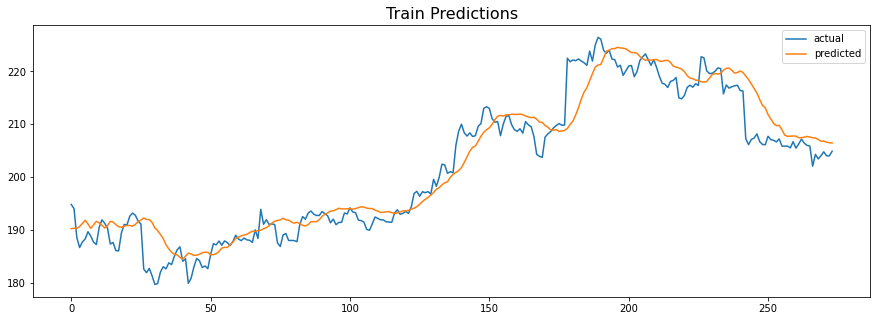

In [66]:
rnn_forecast = model_forecast(model,X,window_size)
rnn_forecast = rnn_forecast[:-1, 0]

plt.figure(figsize=(15, 5))
plt.plot(y[window_size:],label='actual')
plt.plot(rnn_forecast,label='predicted')
plt.title('Train Predictions',fontsize=16)
plt.legend()
plt.show()

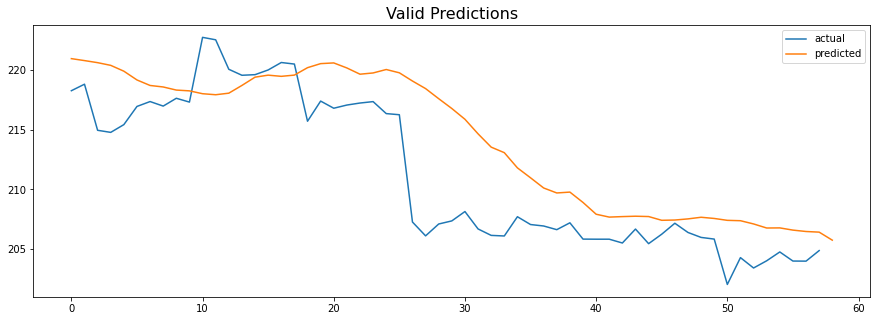

In [67]:
rnn_forecast = model_forecast(model, X[-window_size-y_valid.shape[0]:], window_size)
# rnn_forecast = rnn_forecast[-1, :, 0]

plt.figure(figsize=(15, 5))
plt.plot(y_valid,label='actual')
plt.plot(rnn_forecast,label='predicted')
plt.title('Valid Predictions',fontsize=16)
plt.legend()
plt.show()